In [1]:
import pandas as pd
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.max_colwidth = 100

# Compile all together

## Read files

In [4]:
train_df = pd.read_json('train.json', orient='index').sort_index()
train_df['source'] = 'train'

In [5]:
dev_df = pd.read_json('devset.json', orient='index')
dev_df['source'] = 'dev'

In [6]:
test_df = pd.read_json('test-unlabelled.json', orient='index')
test_df['source'] = 'test'

## Generate list of all claims

In [7]:
cols = ['claim', 'source']
claims_df = pd.concat([train_df[cols], dev_df[cols], test_df[cols]]).sort_index()
claims_df.index.name = 'claim_id'
claims_df.to_csv('data/claims.csv')
claims_df.shape

(165447, 2)

In [8]:
claims_df.pivot_table(columns='source', aggfunc='count')

source,dev,test,train
claim,5001,14997,145449


In [9]:
claims_df.head()

,claim,source
claim_id,,
3,Chris Hemsworth appeared in A Perfect Getaway.,train
4,Chris Hemsworth disappeared in A Perfect Getaway.,train
6,Firefox is an application.,test
7,Roald Dahl is a writer.,train
8,Roald Dahl is a governor.,train


## Generate list of labelled claims

In [10]:
lclaims_df = pd.concat([train_df, dev_df]).sort_index()
lclaims_df.index.name = 'claim_id'

In [11]:
lclaims_df.shape

(150450, 4)

In [12]:
lclaims_df['evidence_docs'] = lclaims_df.evidence.apply(lambda x: {item[0] for item in x})
lclaims_df['evidence_doc_count'] = lclaims_df.evidence_docs.apply(lambda x: len(x))
lclaims_df['evidence_sentence_count'] = lclaims_df.evidence.apply(lambda x: len(x))

In [13]:
lclaims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count
claim_id,,,,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[Chris_Hemsworth, 2]]",SUPPORTS,train,{Chris_Hemsworth},1,1
4,Chris Hemsworth disappeared in A Perfect Getaway.,[],NOT ENOUGH INFO,train,{},0,0
7,Roald Dahl is a writer.,"[[Roald_Dahl, 0]]",SUPPORTS,train,{Roald_Dahl},1,1
8,Roald Dahl is a governor.,"[[Roald_Dahl, 0]]",REFUTES,train,{Roald_Dahl},1,1
9,Ireland has relatively low-lying mountains.,"[[Ireland, 10]]",SUPPORTS,train,{Ireland},1,1


### Evidence Counts

In [14]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0, margins=True)
stat_df[stat_df.All > 100]

label,NOT ENOUGH INFO,REFUTES,SUPPORTS,All
evidence_doc_count,,,,
0,37306,0,0,37306
1,0,26806,67517,94323
2,0,3459,10754,14213
3,0,537,1575,2112
4,0,208,651,859
5,0,148,400,548
6,0,82,248,330
7,0,56,188,244
8,0,43,130,173


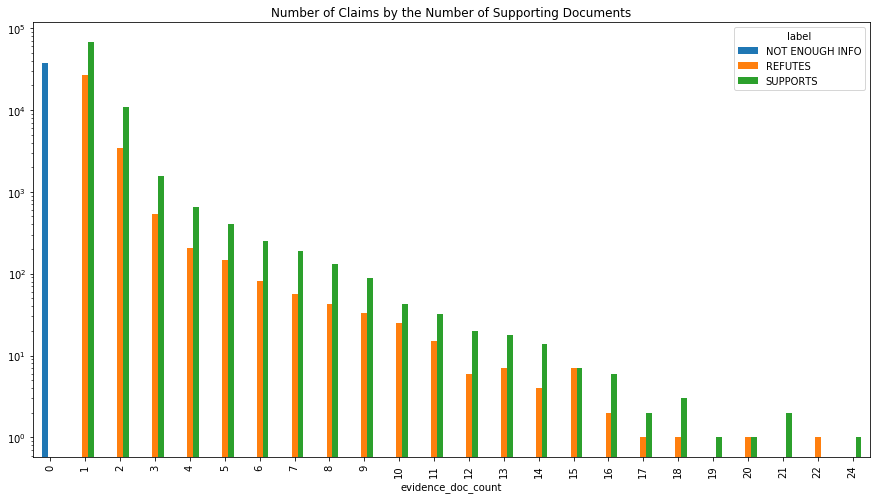

In [15]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0)
stat_df.plot.bar(figsize=(15, 8), logy=True, title='Number of Claims by the Number of Supporting Documents')
plt.show()

### Most Popular Evidence

In [16]:
lclaims_df['evidence_set_str'] = lclaims_df.evidence_docs.astype(str)
mask = lclaims_df.label != 'NOT ENOUGH INFO'
evidence_stat = lclaims_df[mask].evidence_set_str.value_counts()
evidence_stat.index.name = 'evidence_set'
evidence_stat = evidence_stat.reset_index()
evidence_stat.head(20)

,evidence_set,evidence_set_str
0,{'Snoop_Dogg'},166
1,{'Wyatt_Earp'},151
2,{'United_Kingdom'},140
3,{'International_relations'},139
4,{'Marlon_Brando'},137
5,{'United_States'},132
6,{'Adele'},130
7,{'Abraham_Lincoln'},125
8,{'Miley_Cyrus'},120
9,{'Michael_Jackson'},119


In [17]:
evidence_stat = lclaims_df[mask].pivot_table(index=['evidence_set_str', 'evidence_doc_count'], 
                                             values='claim', aggfunc='count').reset_index()

### Claims with Multiple evidence

In [18]:
evidence_stat[evidence_stat.evidence_doc_count > 1].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
488,"{'A_Song_of_Ice_and_Fire', 'George_R._R._Martin'}",2,42
1510,"{'Audrey_Horne', 'Pilot_-LRB-Twin_Peaks-RRB-'}",2,32
5492,"{'Grace_Jones', 'Warm_Leatherette_-LRB-album-RRB-'}",2,26
8724,"{'Mel_B', 'Hot_-LRB-Mel_B_album-RRB-'}",2,26
6672,"{'Jay_Baruchel', 'Gift_of_the_Night_Fury'}",2,23
10863,"{'Richard_Nixon', 'Pat_Nixon'}",2,22
6866,"{'Joan_Cusack', 'In_&_Out_-LRB-film-RRB-'}",2,20
7924,"{'Lindsay_Anderson', 'This_Sporting_Life'}",2,20
5640,"{'Grégory_Levasseur', 'Furia_-LRB-film-RRB-'}",2,19
9060,"{'Mitt_Romney', 'Ann_Romney'}",2,19


In [19]:
evidence_stat[evidence_stat.evidence_doc_count > 3].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
979,"{'America_Ferrera', 'T._J._Miller', 'Christopher_Mintz-Plasse', 'Kristen_Wiig', 'Gerard_Butler',...",9,7
11011,"{'Rodeo_-LRB-Travis_Scott_album-RRB-', 'Birds_in_the_Trap_Sing_McKnight', 'Days_Before_Rodeo', '...",5,7
1068,"{'An_Officer_and_a_Gentleman', 'American_Gigolo', 'Richard_Gere', 'Days_of_Heaven'}",4,7
497,"{'A_Storm_of_Swords', 'A_Game_of_Thrones', 'A_Feast_for_Crows', 'Gendry', 'A_Clash_of_Kings'}",5,5
3482,"{'Danny_Huston', 'Jeff_Bridges', 'How_to_Lose_Friends_&_Alienate_People_-LRB-film-RRB-', 'Simon_...",5,5
2688,"{'Castaway_-LRB-film-RRB-', 'The_Trap_-LRB-1966_film-RRB-', 'Gladiator_-LRB-2000_film-RRB-', 'Ol...",4,5
1942,"{'Bill_Murray', 'Owen_Wilson', 'Danny_Glover', 'Ben_Stiller', 'Gene_Hackman', 'Luke_Wilson', 'Th...",7,5
7960,"{'Lisa_Kudrow', 'Web_Therapy_-LRB-TV_series-RRB-', 'The_Comeback_-LRB-TV_series-RRB-', 'Friends'}",4,4
4468,"{'Eric_Kretz', 'Dean_DeLeo', 'Robert_DeLeo', 'Stone_Temple_Pilots', 'Scott_Weiland'}",5,4
13054,"{'The_Host_-LRB-2013_film-RRB-', 'Diane_Kruger', 'Jake_Abel', 'Max_Irons', 'Saoirse_Ronan', 'Wil...",6,4


In [20]:
lclaims_df[lclaims_df.evidence_doc_count > 10].head(20)

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
claim_id,,,,,,,,
877,Keith Urban is a singer.,"[[Break_on_Me, 1], [Keith_Urban_-LRB-1991_album-RRB-, 0], [Keith_Urban, 18], [Golden_Road_-LRB-a...",SUPPORTS,train,"{Break_on_Me, Sweet_Thing_-LRB-Keith_Urban_song-RRB-, But_for_the_Grace_of_God, The_Ranch_-LRB-b...",11,22,"{'Break_on_Me', 'Sweet_Thing_-LRB-Keith_Urban_song-RRB-', 'But_for_the_Grace_of_God', 'The_Ranch..."
1885,Leonardo DiCaprio is an actor.,"[[Blood_Diamond, 0], [Leonardo_DiCaprio, 8], [Leonardo_DiCaprio, 1], [Inception, 1], [Shutter_Is...",SUPPORTS,train,"{Martin_Scorsese, The_Great_Gatsby_-LRB-2013_film-RRB-, The_Departed, The_Wolf_of_Wall_Street_-L...",24,40,"{'Martin_Scorsese', 'The_Great_Gatsby_-LRB-2013_film-RRB-', 'The_Departed', 'The_Wolf_of_Wall_St..."
7253,Laurence Fishburne acted in a movie.,"[[Man_of_Steel_-LRB-film-RRB-, 4], [Othello_-LRB-1995_film-RRB-, 0], [Academy_Award_for_Best_Act...",SUPPORTS,train,"{Laurence_Fishburne, Man_of_Steel_-LRB-film-RRB-, The_Matrix_-LRB-franchise-RRB-, Apocalypse_Now...",11,27,"{'Laurence_Fishburne', 'Man_of_Steel_-LRB-film-RRB-', 'The_Matrix_-LRB-franchise-RRB-', 'Apocaly..."
7540,Scarlett Johansson is an actress.,"[[Lucy_-LRB-2014_film-RRB-, 0], [Scarlett_Johansson, 3], [Ghost_World_-LRB-film-RRB-, 0], [Manny...",SUPPORTS,train,"{Scarlett_Johansson, Anywhere_I_Lay_My_Head, North_-LRB-1994_film-RRB-, Ghost_in_the_Shell_-LRB-...",21,38,"{'Scarlett_Johansson', 'Anywhere_I_Lay_My_Head', 'North_-LRB-1994_film-RRB-', 'Ghost_in_the_Shel..."
7541,Scarlett Johansson is an actress in films.,"[[Girl_with_a_Pearl_Earring_-LRB-film-RRB-, 16], [Lucy_-LRB-2014_film-RRB-, 0], [Ghost_World_-LR...",SUPPORTS,train,"{Scarlett_Johansson, Marvel_Cinematic_Universe, Ghost_in_the_Shell_-LRB-2017_film-RRB-, A_Love_S...",20,40,"{'Scarlett_Johansson', 'Marvel_Cinematic_Universe', 'Ghost_in_the_Shell_-LRB-2017_film-RRB-', 'A..."
7623,Slovakia is a warship.,"[[Slovakia, 4], [Democracy_Index, 0], [Slovakia, 19], [Social_security, 6], [Slovakia, 26], [Slo...",REFUTES,train,"{European_Union, Democracy_Index, List_of_countries_by_real_GDP_growth_rate, Velvet_Revolution, ...",16,39,"{'European_Union', 'Democracy_Index', 'List_of_countries_by_real_GDP_growth_rate', 'Velvet_Revol..."
7747,Julie Christie starred in a film.,"[[The_Go-Between_-LRB-1971_film-RRB-, 0], [Away_from_Her, 0], [Julie_Christie, 8], [Darling_-LRB...",SUPPORTS,train,"{Troy_-LRB-film-RRB-, The_Go-Between_-LRB-1971_film-RRB-, Darling_-LRB-1965_film-RRB-, Away_from...",13,17,"{'Troy_-LRB-film-RRB-', 'The_Go-Between_-LRB-1971_film-RRB-', 'Darling_-LRB-1965_film-RRB-', 'Aw..."
7886,George W. Bush was a president.,"[[George_W._Bush, 10], [George_W._Bush, 28], [Barbara_Bush, 1], [George_W._Bush, 5], [United_Sta...",SUPPORTS,train,"{George_W._Bush, Bush_Doctrine, Jeb_Bush, Patriot_Act, Decision_Points, Laura_Bush, United_State...",14,30,"{'George_W._Bush', 'Bush_Doctrine', 'Jeb_Bush', 'Patriot_Act', 'Decision_Points', 'Laura_Bush', ..."
8089,Gennady Golovkin boxes.,"[[Gennady_Golovkin, 5], [Interim_championship, 0], [Milton_Núñez_-LRB-boxer-RRB-, 1], [Gennady...",SUPPORTS,train,"{The_Ring_magazine_Pound_for_Pound, Transnational_Boxing_Rankings_Board, International_Boxing_Fe...",16,28,"{'The_Ring_magazine_Pound_for_Pound', 'Transnational_Boxing_Rankings_Board', 'International_Boxi..."


In [21]:
lclaims_df.to_json('data/l_claims.json')

# Explore claims

In [22]:
#!sudo python3 -m pip install spacy
#!sudo python3 -m spacy download en_core_web_lg

In [23]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

In [51]:
def parse_with_spacy(text):
    doc = nlp(text)
    record = dict(
        named_entities = [{'entity': span.text, 'label': span.label_, 'root': span.root.text} for span in doc.ents],
        noun_phrases = [{'noun_phrase': span.text, 'root': span.root.text} for span in doc.noun_chunks]
    )
    return record

## Read Claims list

In [52]:
claims_df = pd.read_csv('data/claims.csv', index_col='claim_id')

## Calculate features

!sudo python3 -m pip install pandarallel

In [54]:
#!sudo python3 -m pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [55]:
from pandarallel import pandarallel

In [56]:
%%time
pandarallel.initialize(progress_bar=True, nb_workers=6)
features = claims_df.claim.parallel_apply(parse_with_spacy)

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 6 workers








CPU times: user 15.5 s, sys: 5.58 s, total: 21.1 s
Wall time: 4min 28s


In [59]:
features.name = 'parse'
claims_df = claims_df.join(features)

%%time
records = []
for claim_id, claim in claims_df.claim.items():
    if (claim_id % 1000 == 0):
        print(claim_id)
    
    record = parse_with_spacy(claim)
    record['claim_id'] = claim_id
    records.append(record)
    #print()

In [60]:
claims_features_df = claims_df

In [61]:
#claims_features_df = pd.DataFrame.from_records(records, index='claim_id')
#claims_features_df.rename(columns={'noun_chunks': 'noun_phrases'}, inplace=True)

In [67]:
claims_features_df['entity_count'] = claims_features_df.parse.apply(lambda x: len(x['named_entities']))
claims_features_df['entity_types'] = claims_features_df.parse.apply(lambda x: {item['label'] for item in x['named_entities']})
claims_features_df['entity_types_count'] = claims_features_df.entity_types.apply(len)

In [69]:
claims_features_df['np_count'] = claims_features_df.parse.apply(lambda x: len(x['noun_phrases']))
func = lambda x: {item['noun_phrase'] for item in x['noun_phrases']}
claims_features_df['np_phrase'] = claims_features_df.parse.apply(func)
claims_features_df['np_roots'] = claims_features_df.parse.apply(lambda x: {item['root'] for item in x['noun_phrases']})

## Export claims with features

In [72]:
#del claims_df[]

In [73]:
#claims_df = claims_df.join(claims_features_df)

In [74]:
claims_df.head(5)

,claim,source,parse,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots
claim_id,,,,,,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,train,"{'named_entities': [{'root': 'Hemsworth', 'entity': 'Chris Hemsworth', 'label': 'PERSON'}, {'roo...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}"
4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"{'named_entities': [{'root': 'Hemsworth', 'entity': 'Chris Hemsworth', 'label': 'PERSON'}, {'roo...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}"
6,Firefox is an application.,test,"{'named_entities': [{'root': 'Firefox', 'entity': 'Firefox', 'label': 'ORG'}], 'noun_phrases': [...",1,{ORG},1,2,"{Firefox, an application}","{Firefox, application}"
7,Roald Dahl is a writer.,train,"{'named_entities': [{'root': 'Dahl', 'entity': 'Roald Dahl', 'label': 'PERSON'}], 'noun_phrases'...",1,{PERSON},1,2,"{Roald Dahl, a writer}","{Dahl, writer}"
8,Roald Dahl is a governor.,train,"{'named_entities': [{'root': 'Dahl', 'entity': 'Roald Dahl', 'label': 'PERSON'}], 'noun_phrases'...",1,{PERSON},1,2,"{a governor, Roald Dahl}","{Dahl, governor}"


In [75]:
claims_df.to_json('data/claims_lm.json')

## Top entity types

In [76]:
claims_features_df['entity_types_str'] = claims_features_df.entity_types.astype(str)
claims_features_df.reset_index(inplace=True)
#claims_data_df['entity_types_count'] = claims_data_df.entity_types.apply(len)

In [77]:
claims_features_df

,claim_id,claim,source,parse,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots,entity_types_str
0,3,Chris Hemsworth appeared in A Perfect Getaway.,train,"{'named_entities': [{'root': 'Hemsworth', 'entity': 'Chris Hemsworth', 'label': 'PERSON'}, {'roo...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}","{'WORK_OF_ART', 'PERSON'}"
1,4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"{'named_entities': [{'root': 'Hemsworth', 'entity': 'Chris Hemsworth', 'label': 'PERSON'}, {'roo...",2,"{WORK_OF_ART, PERSON}",2,2,"{Chris Hemsworth, A Perfect Getaway}","{Getaway, Hemsworth}","{'WORK_OF_ART', 'PERSON'}"
2,6,Firefox is an application.,test,"{'named_entities': [{'root': 'Firefox', 'entity': 'Firefox', 'label': 'ORG'}], 'noun_phrases': [...",1,{ORG},1,2,"{Firefox, an application}","{Firefox, application}",{'ORG'}
3,7,Roald Dahl is a writer.,train,"{'named_entities': [{'root': 'Dahl', 'entity': 'Roald Dahl', 'label': 'PERSON'}], 'noun_phrases'...",1,{PERSON},1,2,"{Roald Dahl, a writer}","{Dahl, writer}",{'PERSON'}
4,8,Roald Dahl is a governor.,train,"{'named_entities': [{'root': 'Dahl', 'entity': 'Roald Dahl', 'label': 'PERSON'}], 'noun_phrases'...",1,{PERSON},1,2,"{a governor, Roald Dahl}","{Dahl, governor}",{'PERSON'}
5,9,Ireland has relatively low-lying mountains.,train,"{'named_entities': [{'root': 'Ireland', 'entity': 'Ireland', 'label': 'GPE'}], 'noun_phrases': [...",1,{GPE},1,2,"{relatively low-lying mountains, Ireland}","{mountains, Ireland}",{'GPE'}
6,10,Ireland does not have relatively low-lying mountains.,train,"{'named_entities': [{'root': 'Ireland', 'entity': 'Ireland', 'label': 'GPE'}], 'noun_phrases': [...",1,{GPE},1,2,"{relatively low-lying mountains, Ireland}","{mountains, Ireland}",{'GPE'}
7,11,Carlos Santana formed Santana in 1966.,test,"{'named_entities': [{'root': 'Santana', 'entity': 'Carlos Santana', 'label': 'PERSON'}, {'root':...",3,"{DATE, PERSON}",2,2,"{Santana, Carlos Santana}",{Santana},"{'DATE', 'PERSON'}"
8,12,Carlos Santana disbanded Santana in 1965.,dev,"{'named_entities': [{'root': 'Santana', 'entity': 'Carlos Santana', 'label': 'PERSON'}, {'root':...",3,"{DATE, PERSON}",2,2,"{Santana, Carlos Santana}",{Santana},"{'DATE', 'PERSON'}"
9,13,David Thewis has had many notable performances.,train,"{'named_entities': [{'root': 'Thewis', 'entity': 'David Thewis', 'label': 'PERSON'}], 'noun_phra...",1,{PERSON},1,2,"{many notable performances, David Thewis}","{Thewis, performances}",{'PERSON'}


In [78]:
df = claims_features_df.pivot_table(index=['entity_types_count', 'entity_types_str'], 
                           aggfunc='count', values='claim_id').reset_index()
df.rename(columns={'claim_id': 'claims_count'}, inplace=True)
df.sort_values(['entity_types_count', 'claims_count'], ascending=[True, False]).reset_index(drop=True)

,entity_types_count,entity_types_str,claims_count
0,0,set(),11646
1,1,{'PERSON'},44981
2,1,{'ORG'},13589
3,1,{'GPE'},8146
4,1,{'DATE'},3021
5,1,{'NORP'},2071
6,1,{'CARDINAL'},1409
7,1,{'WORK_OF_ART'},1069
8,1,{'LOC'},937
9,1,{'PRODUCT'},439


In [79]:
df = claims_features_df.pivot_table(index=['np_count'], 
                           aggfunc='count', values='claim_id').reset_index()
df.rename(columns={'claim_id': 'claims_count'}, inplace=True)
df.sort_values(['np_count'], ascending=[True]).reset_index(drop=True)

,np_count,claims_count
0,0,145
1,1,13291
2,2,86872
3,3,45613
4,4,14030
5,5,3735
6,6,1012
7,7,290
8,8,122
9,9,86


In [80]:
claims_df[claims_df.np_count == 0]

,claim_id,claim,source,parse,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots,entity_types_str
1033,1443,Michael J. Fox semi-retired from acting in 2000.,train,"{'named_entities': [{'root': 'Fox', 'entity': 'Michael J. Fox', 'label': 'PERSON'}, {'root': '20...",2,"{DATE, PERSON}",2,0,{},{},"{'DATE', 'PERSON'}"
4649,6344,There are at least 10 James Bond shows.,train,"{'named_entities': [{'root': '10', 'entity': 'at least 10', 'label': 'CARDINAL'}, {'root': 'Bond...",2,"{CARDINAL, PERSON}",2,0,{},{},"{'CARDINAL', 'PERSON'}"
6449,8692,The Conjuring 2 was released in 2016.,train,"{'named_entities': [{'root': '2', 'entity': 'The Conjuring 2', 'label': 'ORG'}, {'root': '2016',...",2,"{DATE, ORG}",2,0,{},{},"{'DATE', 'ORG'}"
7068,9532,Younger premiered in 2015.,test,"{'named_entities': [{'root': '2015', 'entity': '2015', 'label': 'DATE'}], 'noun_phrases': []}",1,{DATE},1,0,{},{},{'DATE'}
7902,10670,Flaked was cancelled in 2016.,test,"{'named_entities': [{'root': '2016', 'entity': '2016', 'label': 'DATE'}], 'noun_phrases': []}",1,{DATE},1,0,{},{},{'DATE'}
8488,11486,Furious 7 is American.,train,"{'named_entities': [{'root': 'American', 'entity': 'American', 'label': 'NORP'}], 'noun_phrases'...",1,{NORP},1,0,{},{},{'NORP'}
8919,12059,MS-13 is kind.,test,"{'named_entities': [], 'noun_phrases': []}",0,{},0,0,{},{},set()
9694,13095,Furious 7 began filming in 2013.,train,"{'named_entities': [{'root': '2013', 'entity': '2013', 'label': 'DATE'}], 'noun_phrases': []}",1,{DATE},1,0,{},{},{'DATE'}
9695,13096,Furious 7 began showing in 2013.,train,"{'named_entities': [{'root': '2013', 'entity': '2013', 'label': 'DATE'}], 'noun_phrases': []}",1,{DATE},1,0,{},{},{'DATE'}
10111,13663,Knocked Up grossed $219 million worldwide.,dev,"{'named_entities': [{'root': 'million', 'entity': '$219 million', 'label': 'MONEY'}], 'noun_phra...",1,{MONEY},1,0,{},{},{'MONEY'}
